# Time Series EDA

In this lesson we will discuss multiple different visualizations for exploring time series data. The primary use case for Time Series EDA techniques is when we have a single continuous variable sampled over time and we want to identify **trend** and **seasonality**.

### Setup
We'll be looking at temperature data for san antonio from late 2012 to late 2017.

We'll need to convert from Kelvin to Fahrenheit.

°F = (K - 273.15) x 1.8000 + 32.00

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [3]:
url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00
Shape: (45252, 1)


,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
2012-10-01 18:00:00,61.327473
2012-10-01 19:00:00,61.390200
2012-10-01 20:00:00,61.452926
2012-10-01 21:00:00,61.515652


#### Seasonality
A repeated cycle in the data. Occurs at fixed frequency. In our weather data there is yearly and daily seasonality.

#### Trend
Long term upwards or downwards movement

#### Cycle
Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

### Data Splitting
- Ideally all splits contain a season
- Human-based: Using domain knowledge, a cutoff is selected. (ex: use the last year as Test)
- Percentage-based: A cutoff is selected arbitrarily (ex: use the last 20% of observations as Test)
- Cross-validation-based: Break data into slices and use successive slices as train and test repeatedly

`sklearn.model_selection.TimeSeriesSplit`

### Percentage Based

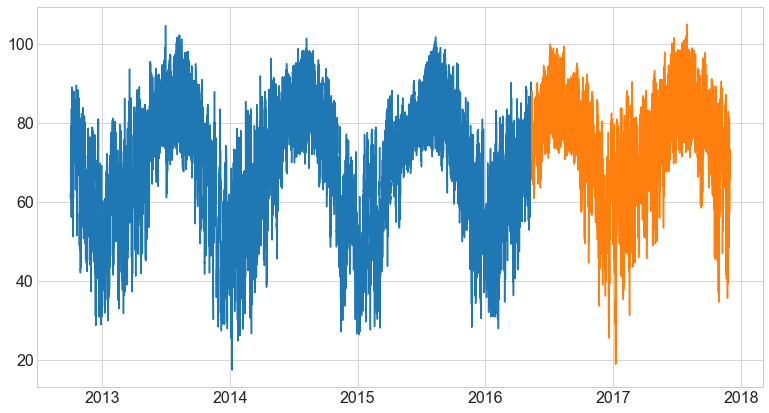

In [4]:
train_size = 0.70 # 70% train, 30% test
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # Everything up to but not including the test_start_index
test = df[test_start_index:] # Everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

### Human-Based

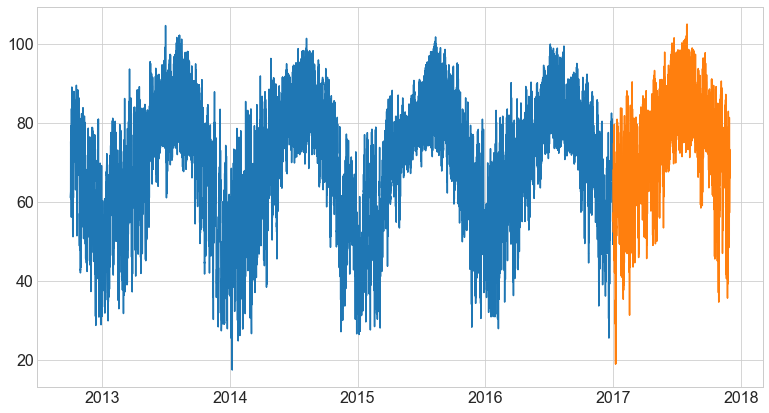

In [5]:
train = df[:'2016'] # includes 2016
test = df['2017'] 

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

For now, we will choose to use the data from 2017 as our test data split and explore the data up to 2017. We can choose to repeat this process to create a validate split. 

### Visualizations

Now we will discuss several techniques for time series data visualization.

We'll store our target in a variable named y for ease of access, but we will jump back and forth between our `train` DataFrame object and our `y` Series object as we see fit.

In [ ]:
y = train.temp
y.head()

### Basic Histogram (Ignoring Time Component)

In [ ]:
plt.title('Distribution of Temperature')
plt.xlabel('Temperature in Fahrenheit')
y.plot.hist(linewidth=1.2, edgecolor='black')

We can treat components of the date as separate categorical features. 

For example, what if we wanted to extract "month" from our dates and use that to group our data?

<div class="alert alert-info">
    <p><strong>Aside: Month and Weekday Ordering</strong></p>
    <p>By default, matplotlib/pandas will sort months and weekdays alphabetically, which is usually not what we want.</p>
    <p>There are several ways to work around this:</p>
    <ul>
        <li>Just use the month (1-12) number or weekday number (1-7)</li>
        <li>Instead of using just the month or weekday, use a leading number and then the name (e.g. 1-Jan, 2-Feb)</li>
        <li>Use a combination of the techniques above, and then re-index the resulting pandas object with more human friendly names</li>
        <li>Use a combination of the techniques above, and then manually adjust the labels with matplotlib</li>
    </ul>
</div>

In [ ]:
# make an new column 'month'
train['month'] = train.index.strftime('%m-%b')

In [ ]:
train.head()

In [ ]:
ax = train.groupby(train.month).temp.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='', ylabel='Temp (F)')
plt.show()

In [ ]:
train.groupby('month').describe()

In [ ]:
# boxplot for each month
sns.boxplot(data = train, x = 'month', y = 'temp')

Or we can extract weekday name from our date data:

In [ ]:
train['weekday'] = train.index.day_name()

In [ ]:
train.head()

In [ ]:
sns.barplot(data=train, x='weekday', y='temp', color='steelblue')\
    .set(title='Average Temperature by Day of Week')

In [ ]:
sns.boxplot(x = 'weekday', y = 'temp', data=train) 

### Visualizing the Target Over Time

This can be as simple as calling `.plot` on a dataframe or series with a datetime index.

In [ ]:
y.plot()

We can also resample our target and visualize it over various time periods.

In [ ]:
y.resample('6H').mean().plot(title='6 hour average')

In [ ]:
y.resample('2W').mean().plot(title='2 week average')

We can combine these visualizations to see how the aggregating smoothes out the data.

In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

In addition to resampling, we can calculate moving averages with the `.rolling` method.

In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

### Visualizing Volatility
`.diff` let's us take the difference between the current and previous value

In [ ]:
y.diff().plot(title='Hourly Difference in Temperature')

This is a pretty noisy plot. Its difficult to make anything out. Perhaps looking at % change might give us more insight?

In [ ]:
y.diff()

In [ ]:
y.shift()

In [ ]:
(y.diff() / y.shift()).plot(alpha=.5, lw=3, title='Hourly % Change in Temperature')

Although it's slightly better, we really will need to resample to reduce some of this noise.

In [ ]:
y.resample('W').mean().diff()

In [ ]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature');

In [ ]:
(y.resample('W').mean().diff() / y.resample('W').mean().shift()).plot(title='Average Week-to-Week % Change in Temperature')

In [ ]:
y.resample('W').mean().shift()

In [ ]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature');

In [ ]:
(y.resample('M').mean().diff() / y.resample('M').mean().shift()).plot(title='Average Month-to-Month % Change in Temperature')

### Seasonal Plot
A seasonal plot shows the comparison of multiple seasons together. In this case, our season is one year in length. It is a line plot with the x-axis being the month of the year and the y axis being the target variable. Multiple lines are shown to show multiple years.

In [ ]:
# Start off by getting average temperate for each year-month combination:
y.groupby([y.index.year, y.index.month]).mean()

In [ ]:
# unstack is similar to pivot_table and be used to break up multi-level indices. 
# In this case, we turn the 0 index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0)

In [ ]:
# Run .plot on this object
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()

### Seasonal Subseries Plot
A seasonal subseries plot shows the change year-over-year within each month.

Do not use this plot as part of presentation! This is for EDA only.

In [ ]:
# This is actually the same pivot table as above, but months are on the top and years are on the left
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

In [ ]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)m
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

#### As with the monthly box plot, the seasonal pattern is quite evident in the seasonal subseries.
- Do the data exhibit a seasonal pattern?
- What is the nature of the seasonality?
- Is there a within-group pattern (e.g., do January and July exhibit similar patterns)?
- Are there any outliers once seasonality has been accounted for?
- Should I use box plot instead?

### What if seasonality is not that readily apparent?

Is there a seasonality in this data?

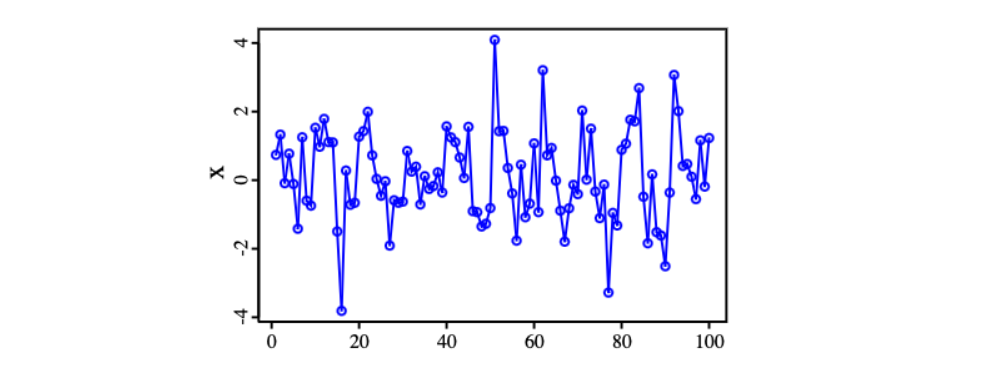

### Lag Plot

A lag plot is a scatter plot of a series with itself, shifted, or lagged. Put another way, a lag plot measures one value against the next or previous value.

If your data is sampled daily, you could think of `t` as 'today', `t+1` is 'tomorrow'. More generally, `t` is any given time period and `t+1` is the time period after. If your data is sampled weekly, `t` is any given week, and `t+1` is the following week.

In [ ]:
train['y(t + 1)'] = train.temp.shift(-1)

In [ ]:
train

In [ ]:
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

In [ ]:
del train['y(t + 1)']

In [ ]:
daily = train.resample('D').mean()
daily['temp_next_day'] = daily.temp.shift(-1)
daily.plot.scatter(x='temp', y='temp_next_day')

In [ ]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.head()

In [ ]:
weekly.plot.scatter(x='this_week', y='the_next_week')

In [ ]:
weekly = df.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly.head()

In [ ]:
weekly = df.resample('W').mean()
weekly['26_weeks_out'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='26_weeks_out')
weekly.head()

Note that pandas has a built in `lag_plot()` function that can do some of the work for us:

In [ ]:
# easier way. Use pd.plotting.lag_plot(series, lag):m
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)

### Autocorrelation Plot
**Autocorrelation** is a measure of the linear relationship between lagged values of a time series. An autocorrelation plot shows the correlation coefficient as a function of lag time.

In [ ]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

This can help us identify seasonality by looking at the peaks and valleys of the resulting visualization. The peaks can tells us the frequency with which the seasonality repeats itself, and the valleys show us where the correlation is the most negative.

The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise.

### What does autocorrelation look like for white noise?

In [ ]:
grid = np.linspace(0, 720, 500)
noise = np.random.rand(500)
# result_curve =  noise
plt.plot(grid, noise)

In [ ]:
#plot the autocorrelation for noise

pd.plotting.autocorrelation_plot(noise)

### Seasonal Decomposition

Seasonal decomposition is a fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise1. There are two types of seasonal decomposition models, additive and multiplicative.

$$ y = S + T + \epsilon $$

### data = Seasonality + Trend + Residual

In [ ]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [ ]:
# we can access different attributes of object created above (e.g. seasonal, trend and resid)
result.seasonal

In [ ]:
# Make a dataframe:

decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

In [ ]:
decomposition.iloc[:, 1:].plot()

In [ ]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

### Additive or multiplicative seasonality?


The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. 


https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/

Effectively, with multiplicative seasonality the width of the seasonal pattern is proportional to the level. For additive seasonality it is independent.

### Categories Over Time

In [ ]:
train = train.resample('D').mean()
train.head()

In [ ]:
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').temp.mean()

In [ ]:
train.head()

In [ ]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
# take the existing labels, convert them to Timestamps, and then reformat with .strftime
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);

##### A recent example
https://coronavirus.health.ny.gov/covid-19-variant-data

In [ ]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

In [ ]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

### strftime

A common problem we can run into when visualizing time series data is that the order of the months or days of the week logically is not the same as the order alphabetically. One workaround for this is to format the dates such that the have a number prepended to them (for example, 0-sunday, 1-monday) and the plot. Once the plot is created, we can manipulate the tick labels and remove the prefix.

In [ ]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0);

### Matplotlib Dates

This will only work with plt.plot or ax.plot, not with the pandas plotting!

In [ ]:
# how can i customize the x axis label here?

y.resample('W').mean().plot()
plt.xticks();

In [ ]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

### Exercise
Do your work for this exercise in a notebook named `explore.ipynb`. Use the techniques in the lesson to explore the **store item demand** dataset and the **opsd** dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

**Note: When resampling data, use a `mean()` aggregation method.**

### Store Item Demand
Load your store item demand data using your acquire and/or prepare functions.
1. Using a human-based approach, split your dataset into train and test sets.
2. Visualize your train-test split.

Only use your train data set to perform the following tasks:

3. Resample your data and visualize it.
4. Creating a rolling (moving) average of your data and visualize it.
5. Plot the difference in sales from one day to the next.
6. Plot the % difference in sales from one day to the next.
6. Plot the % difference in sales from one week to the next.
7. Plot the % difference in sales from one month to the next.
8. Visualize an autocorrelation plot on a weekly resampling.
9. Visualize a seasonal decomposition plot on a weekly resampling.

### OPS data
Load your OPS data using your acquire and/or prepare functions.
1. Split the data, so that train contains information up to and including 2013. The remaning data should be placed in test. 

Only use the train data set to perform the following tasks:

2. Visualize your train-test split.
3. Plot the consumption, wind, and solar data on the same chart.
4. Plot only the consumption data from the year 2010. Are there any patterns you can identify? Note them in a markdown section.
5. Resample the consumption data to monthly and plot it.
6. Resample the consumption data to yearly and plot it.

#### BONUS:
7. Group the consumption data by month and create a boxplot treating the month component as a separate categorical feature.
8. Group the consumption data by weekday and create a boxplot treating the weekday component as a separate categorical feature.
9. Create a subseasonal plot by month of your consumption data. 
10. Create one or two visualizations that helps answer the follow questions: How does wind production/consumption vary within a year? How does wind production/consumption vary from year to year?
11. Create one or two visualizations that helps answer the follow questions: How does solar production/consumption vary within a year? How does solar production/consumption vary from year to year?
12. Plot a time series decomposition for your consumption data and note your takeaways.
13. Create an autocorrelation plot of a weekly resampling of the consumption data.